In [14]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
from salishsea_tools import viz_tools, geo_tools,nc_tools
from scipy.interpolate import griddata, interp1d
import matplotlib.cm as cm
import xarray as xr
from grid_alignment import calculate_initial_compass_bearing as cibc

In [2]:
path = '/home/ssahu/saurav/JP_BC/'

In [3]:
gridT = xr.open_dataset(path+'cat_42_days_T.nc')

In [4]:
gridT.coords

Coordinates:
  * deptht        (deptht) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
  * time_counter  (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bnds          (bnds) int64 0 1

In [5]:
gridT.dims

Frozen(SortedKeysDict({'y': 1021, 'bnds': 2, 'time_counter': 43, 'deptht': 50, 'x': 715}))

In [6]:
gridT.attrs

OrderedDict([('Conventions', 'CF-1.1'),
             ('CDI',
              'Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)'),
             ('history',
              'Wed Jul 27 13:01:08 2016: /usr/local/bin/ncrename -O -v lat,nav_lat -v lon,nav_lon /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc\nWed Jul 27 12:36:59 2016: cdo timmean /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/DIMG/NEP036-N30_CU60_20160401_20160332_00813600_grid_T_0000.nc /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/WORKDIR_grid_T_00813600/timmean_grid_T_00813600_0000.nc'),
             ('file_name',
              '/fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc'),
             ('production', 'An IPSL model'),
             ('TimeStamp', '2016-JUL-27 10:02:26 GMT-0000'),
             ('CDO',
              'Climate Data Operators version 1.7.1 (http://mpimet.mpg.de/cdo)')])

In [7]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [8]:
#### Load JP's mask

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc');

tmask_JP = mask.variables['tmask'][0,:,55:400,446:701];
umask_JP = mask.variables['umask'][0,:,55:400,446:701];
vmask_JP = mask.variables['vmask'][0,:,55:400,446:701];

print(tmask_JP.shape, umask_JP.shape, vmask_JP.shape)

(50, 345, 255) (50, 345, 255) (50, 345, 255)


In [9]:
ssh_unfiltered = np.array(gridT['sossheig'][:,55:400,446:701]);
votemper_unfiltered = np.array(gridT['votemper'][:,:,55:400,446:701]);
vosaline_unfiltered = np.array(gridT['vosaline'][:,:,55:400,446:701]);
glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);




for i in np.arange(vosaline_unfiltered.shape[0]):
    vosaline_unfiltered[i,...] = np.ma.masked_array(vosaline_unfiltered[i,...], mask = tmask_JP[...]);
    vosaline_unfiltered[vosaline_unfiltered == 0] = ['Nan'];
    
for i in np.arange(votemper_unfiltered.shape[0]):
    votemper_unfiltered[i,...] = np.ma.masked_array(votemper_unfiltered[i,...], mask = tmask_JP[...]);
    votemper_unfiltered[votemper_unfiltered == 0] = ['Nan'];


In [10]:
# print(votemper_unfiltered.shape)

# for a in np.arange(votemper_unfiltered.shape[0]):
#     for i in np.arange(votemper_unfiltered.shape[1]):
#         for l in np.arange(votemper_unfiltered.shape[2]):
#             for m in np.arange(votemper_unfiltered.shape[3]):
#                 if votemper_unfiltered[a,i,l,m] == 0:
#                     votemper_unfiltered[a,i,l,m] == [];
                    


In [11]:
ssh = np.empty(ssh_unfiltered.shape);
votemper = np.empty(votemper_unfiltered.shape);
vosaline = np.empty(vosaline_unfiltered.shape);
for idx, val in enumerate(ssh_unfiltered[:,...]):
    ssh[idx-1,...] = ssh_unfiltered[idx-2,...]*0.25 + ssh_unfiltered[idx-1,...]*0.5 + \
                                ssh_unfiltered[idx,...]*0.25;
    votemper[idx-1,...] = votemper_unfiltered[idx-2,...]*0.25 + votemper_unfiltered[idx-1,...]*0.5 + \
                                votemper_unfiltered[idx,...]*0.25;
    vosaline[idx-1,...] = vosaline_unfiltered[idx-2,...]*0.25 + vosaline_unfiltered[idx-1,...]*0.5 + \
                                vosaline_unfiltered[idx,...]*0.25;
ssh[0,...] = ssh_unfiltered[0,...];
votemper[0,...] = votemper_unfiltered[0,...];
vosaline[0,...] = vosaline_unfiltered[0,...];
        
print(ssh.shape , votemper.shape, vosaline.shape)

(43, 345, 255) (43, 50, 345, 255) (43, 50, 345, 255)


In [12]:
votemper_unfiltered.shape

(43, 50, 345, 255)

In [13]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

In [14]:
with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 

In [15]:
votemper.shape

(43, 50, 345, 255)

In [16]:
glamt_bc_JP.shape

(345, 255)

In [17]:
np.min(gphit_wcvi)

46.113550613066906

In [18]:
np.min(np.array(gphit_bc_JP))

45.213524

In [19]:
(Nx,Ny) = gphit_wcvi.shape

In [20]:
X = glamt_bc_JP.flatten()

Y = gphit_bc_JP.flatten()

points = (X[:],Y[:])

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];
glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];


xi_left = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten());
xi_right = (glamt_wcvi_bc_right.flatten(), gphit_wcvi_bc_right.flatten());

#votemper_wcvi = np.zeros((43,50,Nx,Ny));

votemper_wcvi_left = np.empty((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
votemper_wcvi_right = np.empty((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));

ssh_wcvi_left = np.empty((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));


for p in np.arange(votemper_wcvi_left.shape[0]):
    for i in np.arange(votemper_wcvi_left.shape[1]):
        votemper_wcvi_left[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        votemper_wcvi_right[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)
#        vosaline_wcvi[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi, method= 'linear', glamt_wcvi.shape))

#vosaline_wcvi = np.reshape(griddata(points, vosaline.flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [21]:
votemper_wcvi_left.shape

(43, 50, 100, 4)

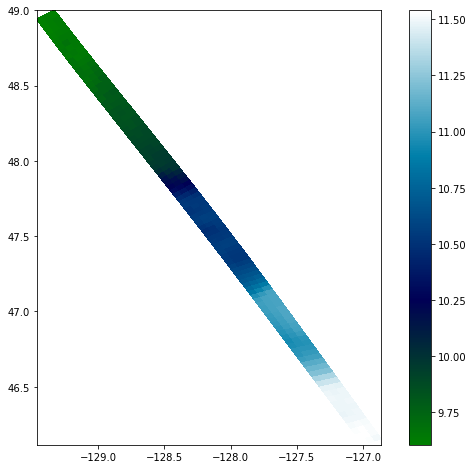

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],votemper_wcvi_left[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


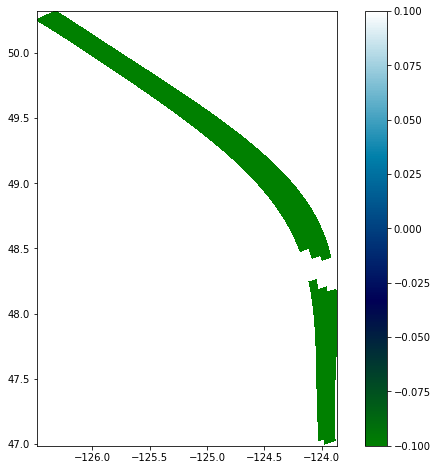

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],votemper_wcvi_right[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [24]:
np.save('votemper_leftbc', votemper_wcvi_left)

In [25]:
np.save('votemper_rightbc', votemper_wcvi_right)

In [26]:
#Now for Salinity


#votemper_wcvi = np.zeros((43,50,Nx,Ny));

vosaline_wcvi_left = np.empty((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
vosaline_wcvi_right = np.empty((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));



for p in np.arange(vosaline_wcvi_left.shape[0]):
    for i in np.arange(vosaline_wcvi_left.shape[1]):
        vosaline_wcvi_left[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        vosaline_wcvi_right[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)



In [27]:
np.save('vosaline_leftbc', vosaline_wcvi_left);
np.save('vosaline_rightbc', vosaline_wcvi_right);

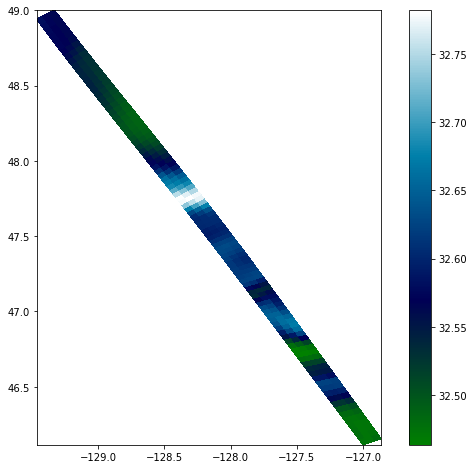

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],vosaline_wcvi_left[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


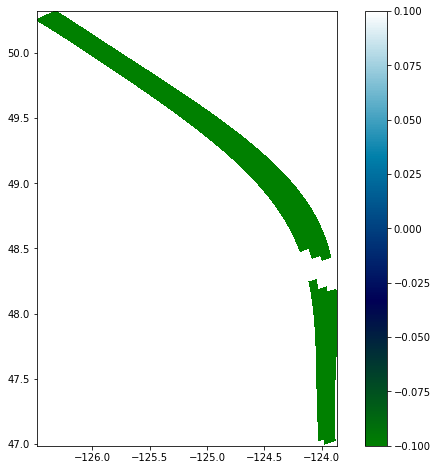

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],votemper_wcvi_right[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [30]:
ssh_wcvi = np.empty((43,Nx,Ny))
for i,j in enumerate(ssh[:,...]):
    ssh_wcvi[i,...] = np.reshape(griddata(points, ssh[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [31]:
#votemper_wcvi.shape

In [32]:
glamt_wcvi.shape

(100, 70)

In [33]:
#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];

glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];

xi = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten())

ssh_wcvi_left = np.empty((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));

ssh_wcvi_right = np.empty((43,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));

for i,j in enumerate(ssh_wcvi_left[:,...]):
    ssh_wcvi_left[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
    ssh_wcvi_right[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)

    
print(glamt_wcvi_bc_right.shape, ssh_wcvi_left.shape)

(100, 4) (43, 100, 4)


In [34]:
np.save('ssh_leftbc', ssh_wcvi_left);
np.save('ssh_rightbc', ssh_wcvi_right)

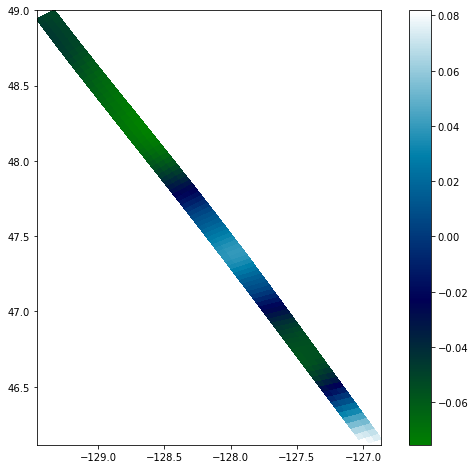

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],ssh_wcvi_left[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

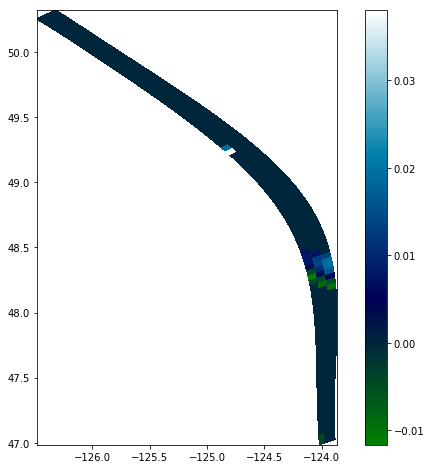

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],ssh_wcvi_right[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [37]:
N = 5

glamt_wcvi_bc_bottom = glamt_wcvi[0:N-1,:]; gphit_wcvi_bc_bottom = gphit_wcvi[0:N-1,:];

glamt_wcvi_bc_top = glamt_wcvi[-N:-1,:]; gphit_wcvi_bc_top = gphit_wcvi[-N:-1,:];

xi_top = (glamt_wcvi_bc_top.flatten(), gphit_wcvi_bc_top.flatten());
xi_bottom = (glamt_wcvi_bc_bottom.flatten(), gphit_wcvi_bc_bottom.flatten());

ssh_wcvi_top = np.empty((43,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));

ssh_wcvi_bottom = np.empty((43,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));

for i,j in enumerate(ssh_wcvi_top[:,...]):
    ssh_wcvi_top[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
    ssh_wcvi_bottom[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

    
print(glamt_wcvi_bc_top.shape, ssh_wcvi_top.shape)

(4, 70) (43, 4, 70)


In [38]:
np.save('ssh_topbc', ssh_wcvi_top);
np.save('ssh_bottombc', ssh_wcvi_bottom)

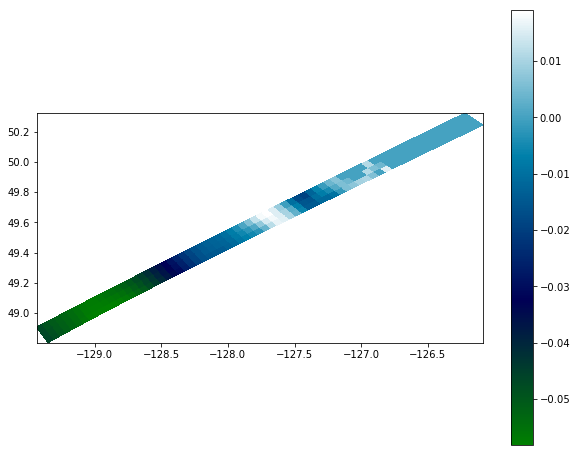

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], ssh_wcvi_top[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

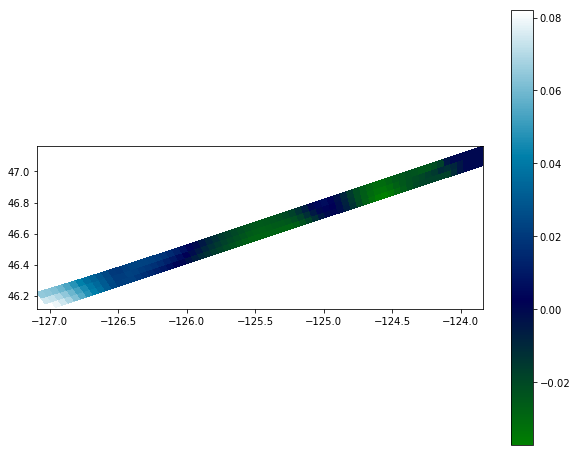

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:],ssh_wcvi_bottom[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

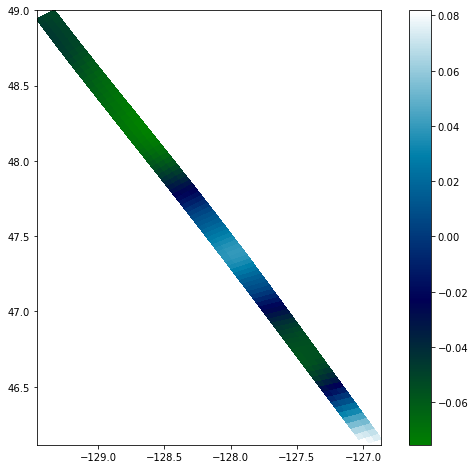

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],ssh_wcvi_left[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

#### Next we would like to interpolate the values of JP to the outer say 5 grid point cells of our domain based on  matching the lats and lons of JP with our domain

In [42]:
#for idx, val in enumerate(votemper_wcvi[0,:,...]):
#    print(idx)

In [43]:
np.array(ssh)

array([[[-0.03121089, -0.03205166, -0.0329079 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03149501, -0.03227666, -0.03311544, ...,  0.        ,
          0.        ,  0.        ],
        [-0.03170847, -0.03246875, -0.0332819 , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.03650894,  0.03562327,  0.03485754, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03556635,  0.03468747,  0.03392269, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0346674 ,  0.03369027,  0.03297989, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.00480135, -0.00555888, -0.00632215, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00492858, -0.00567222, -0.00640438, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00498707, -0.00571611, -0.00646788, ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.0507003 ,  0.04932918,  0.04817919, ...,

In [44]:
ssh.shape

(43, 345, 255)

#### Remaining work
    1) Interpolate to our WCVI grid points of T, S and SSH first 
     2) Slice our domain to keep those variables only for the boundary points (strip of 5 data points on the outer boundary)
     3) Use the filter on the surface T and S points after having sliced them
     4) Do the rotation thingy on U and V points only for the stripped domain (get glamu and gphiu for wcvi and have them on those points
     5) Write a boundary condition file (4 Files one for each boundary) (2D and 3D separately)

In [45]:
#open saved np arrays



In [46]:
X = glamt_bc_JP.flatten()

Y = gphit_bc_JP.flatten()

points = (X[:],Y[:])


#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_bottom = glamt_wcvi[0:N-1,:]; gphit_wcvi_bc_bottom = gphit_wcvi[0:N-1,:];

glamt_wcvi_bc_top = glamt_wcvi[-N:-1,:]; gphit_wcvi_bc_top = gphit_wcvi[-N:-1,:];

xi_top = (glamt_wcvi_bc_top.flatten(), gphit_wcvi_bc_top.flatten());
xi_bottom = (glamt_wcvi_bc_bottom.flatten(), gphit_wcvi_bc_bottom.flatten());
#votemper_wcvi = np.zeros((43,50,Nx,Ny));

votemper_wcvi_top = np.empty((43,50,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));
votemper_wcvi_bottom = np.empty((43,50,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));

vosaline_wcvi_top = np.empty((43,50,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));
vosaline_wcvi_bottom = np.empty((43,50,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));



for p in np.arange(votemper_wcvi_top.shape[0]):
    for i in np.arange(votemper_wcvi_top.shape[1]):
        votemper_wcvi_top[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
        votemper_wcvi_bottom[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

        vosaline_wcvi_top[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
        vosaline_wcvi_bottom[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

        
        #        vosaline_wcvi[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi, method= 'linear', glamt_wcvi.shape))

#vosaline_wcvi = np.reshape(griddata(points, vosaline.flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [47]:
np.save('votemper_topbc', votemper_wcvi_top); np.save('votemper_bottombc', votemper_wcvi_bottom);
np.save('vosaline_topbc', vosaline_wcvi_top); np.save('vosaline_bottombc', vosaline_wcvi_bottom);

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


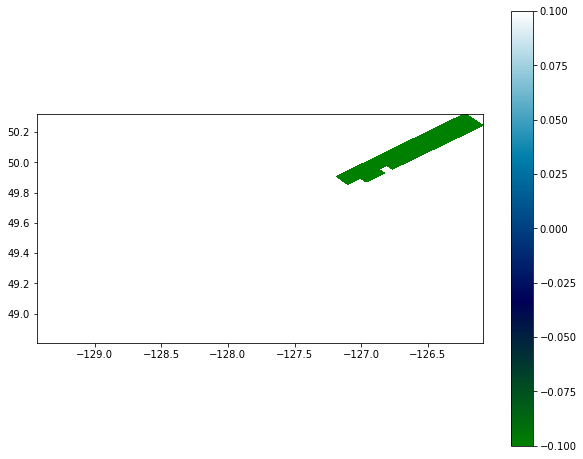

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], votemper_wcvi_top[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


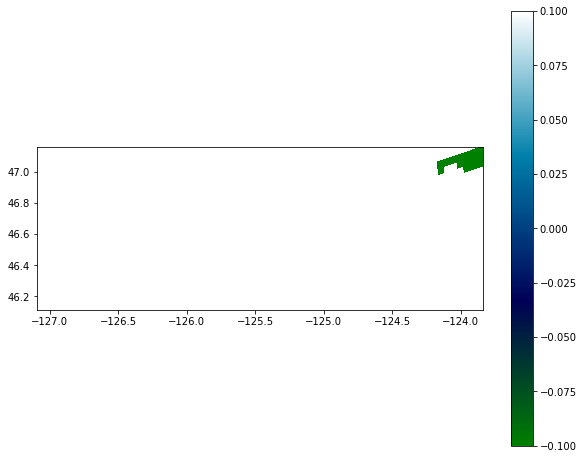

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:], votemper_wcvi_bottom[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


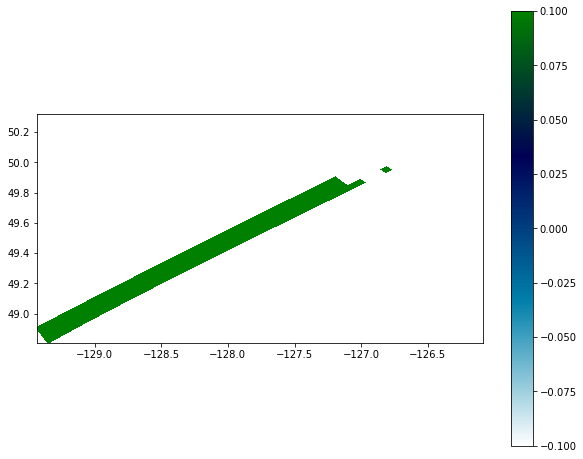

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], vosaline_wcvi_top[0,0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


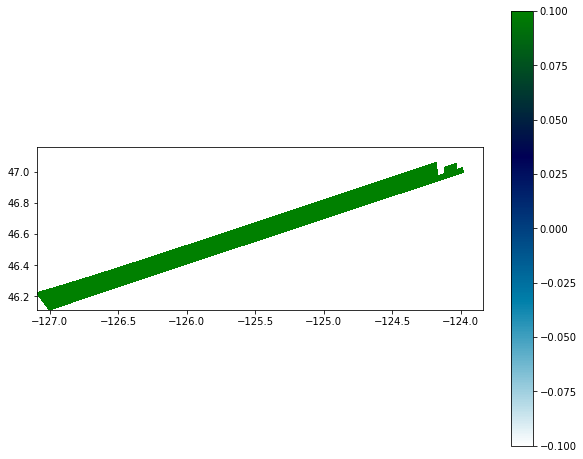

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:], vosaline_wcvi_bottom[0,0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [56]:
votemper_wcvi_bottom[0,:,0,0]

array([ 11.53964838,  11.46232756,  11.36429907,  11.21156111,
        11.08149621,  10.92868684,  10.84826747,  10.79697776,
        10.74934534,  10.70898805,  10.67969265,  10.65905653,
        10.64368129,  10.6304516 ,  10.61863041,  10.60676003,
        10.59034944,  10.54640686,  10.43646863,  10.32520722,
        10.14417778,   9.79899369,   9.25041719,   8.60768142,
         8.2284964 ,   8.00170167,   7.75028367,   7.45028822,
         6.9864759 ,   6.37077407,   5.82359017,   5.28516627,
         4.78809725,   4.37514129,   3.96199117,   3.56378103,
         3.11645274,   2.66194167,   2.19800248,   1.85522205,
         1.65646152,   1.59003038,   1.57470984,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])

In [55]:
!ls

bathy_files
bathy_meter.nc
C:\nppdf32Log\debuglog.txt
coordinates.nc
Dealing_with_FRS_initial_T_and_S_remaking_temp_sal_BC.ipynb
Detiding.ipynb
Fill_up_holes_in_IC_file_and_BC_file.ipynb
grid_alignment.py
Grid_transformation.ipynb
input10
input11
input12
input13
input14
input15
input16
input17
input18
input19
input20
input21
input22
input23
input24
input25
input26
input27
input28
input29
input30
input31
input32
input33
input34
input35
input36
input37
input38
input39
input4
input40
input41
input42
input43
input44
input45
input46
input47
input48
input49
input5
input50
input51
input52
input53
input54
input55
input56
input57
input58
input59
input6
input60
input61
input62
input63
input64
input65
input66
input67
input68
input69
input7
input70
input71
input72
input73
input74
input75
input76
input77
input78
input79
input8
input80
input81
input82
input83
input84
input85
input86
input87
input88
input89
input9
input90
input91
input92
input93
input94
input95
input96
input97
input98
input99
JP_Grid

In [56]:
fname_U_BC = 'cat_43_U.nc'; fname_V_BC = 'cat_43_V.nc';

In [57]:


gridU = xr.open_dataset(path+ fname_U_BC);
gridV = xr.open_dataset(path+ fname_V_BC);



In [58]:
gridU.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, depthu: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * depthu             (depthu) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.269 -142.241 -142.213 -142.186 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    vozocrtx           (time_counter, depthu, y, x) float64 0.0 0.06092 ...
    sozotaux           (time_counter, y, x) float64 0.0 0.01107 0.01111 ...
Attributes:
    Conventions: CF-1.1
    CDI: Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)

In [59]:
gridU.coords

Coordinates:
  * depthu        (depthu) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
  * time_counter  (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bnds          (bnds) int64 0 1

In [60]:
gridU.dims

Frozen(SortedKeysDict({'depthu': 50, 'y': 1021, 'x': 715, 'time_counter': 43, 'bnds': 2}))

In [61]:
gridV.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, depthv: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * depthv             (depthv) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0573 45.0561 45.0549 45.0537 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    vomecrty           (time_counter, depthv, y, x) float64 0.0 0.09244 ...
    sometauy           (time_counter, y, x) float64 0.0 0.01886 0.01835 ...
Attributes:
    Conventions: CF-1.1
    CDI: Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)
 

In [62]:
#nav_lon_T = np.array(gridT['nav_lon'][55:400,446:701]);
#nav_lat_T = np.array(gridT['nav_lat'][55:400,446:701]);

nav_lon_U = np.array(gridU['nav_lon'][55:400,446:701]);
nav_lat_U = np.array(gridU['nav_lat'][55:400,446:701]);

nav_lon_V = np.array(gridV['nav_lon'][55:400,446:701]);
nav_lat_V = np.array(gridV['nav_lat'][55:400,446:701]); 

U_vel_BC_unfiltered = np.array(gridU['vozocrtx'][:,:,55:400,446:701]);
V_vel_BC_unfiltered = np.array(gridV['vomecrty'][:,:,55:400,446:701]);


for a in np.arange(U_vel_BC_unfiltered.shape[0]):
    for i in np.arange(U_vel_BC_unfiltered.shape[1]):
        for l in np.arange(U_vel_BC_unfiltered.shape[2]):
            for m in np.arange(U_vel_BC_unfiltered.shape[3]):
                if U_vel_BC_unfiltered[a,i,l,m] == 0:
                    U_vel_BC_unfiltered[a,i,l,m] == [];


for a in np.arange(V_vel_BC_unfiltered.shape[0]):
    for i in np.arange(V_vel_BC_unfiltered.shape[1]):
        for l in np.arange(V_vel_BC_unfiltered.shape[2]):
            for m in np.arange(V_vel_BC_unfiltered.shape[3]):
                if V_vel_BC_unfiltered[a,i,l,m] == 0:
                    V_vel_BC_unfiltered[a,i,l,m] == [];

                    
                    
#votemper = np.array(gridT['votemper'][:,:,55:400,446:701]);
#vosaline = np.array(gridT['vosaline'][:,:,55:400,446:701])
#glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
#gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);

In [63]:
U_vel_BC = np.empty(U_vel_BC_unfiltered.shape);
V_vel_BC = np.empty(V_vel_BC_unfiltered.shape);
for idx, val in enumerate(U_vel_BC_unfiltered[:,...]):
    U_vel_BC[idx-1,...] = U_vel_BC_unfiltered[idx-2,...]*0.25 + U_vel_BC_unfiltered[idx-1,...]*0.5 + \
                                U_vel_BC_unfiltered[idx,...]*0.25;
    V_vel_BC[idx-1,...] = V_vel_BC_unfiltered[idx-2,...]*0.25 + V_vel_BC_unfiltered[idx-1,...]*0.5 + \
                                V_vel_BC_unfiltered[idx,...]*0.25;
    
print(U_vel_BC.shape, V_vel_BC.shape)

(43, 50, 345, 255) (43, 50, 345, 255)


In [64]:
fname_mask = 'mesh_mask.nc'
mask = xr.open_dataset(path+ fname_mask)


In [65]:
mask.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:       (t: 1, x: 715, y: 1021, z: 50)
Coordinates:
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * z             (z) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * t             (t) int64 0
Data variables:
    nav_lon       (y, x) float32 -142.283 -142.256 -142.228 -142.2 -142.173 ...
    nav_lat       (y, x) float32 45.0491 45.0479 45.0467 45.0456 45.0444 ...
    nav_lev       (z) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
    time_counter  (t) float64 0.0
    tmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    umask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    vmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    fmask         (t, z, y, x) int8 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    tmaskutil     (t, 

In [66]:
#nav_lon_T.shape


In [67]:
t_mask = mask['tmask'][0,:,55:400,446:701];

for i,j in enumerate (U_vel_BC[:,...]):
    U_vel_BC[i,...] = ma.masked_array(U_vel_BC[i,...], mask = 1- t_mask[...])
    V_vel_BC[i,...] = ma.masked_array(V_vel_BC[i, ...], mask = 1- t_mask[...])
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_vel_BC_tzyx, v_vel_BC_tzyx = viz_tools.unstagger(U_vel_BC, V_vel_BC)

mag_vel_BC = np.sqrt(np.multiply(u_vel_BC_tzyx,u_vel_BC_tzyx), np.multiply(v_vel_BC_tzyx,v_vel_BC_tzyx));
ang_vel_BC = np.degrees(np.arctan2(v_vel_BC_tzyx, u_vel_BC_tzyx));







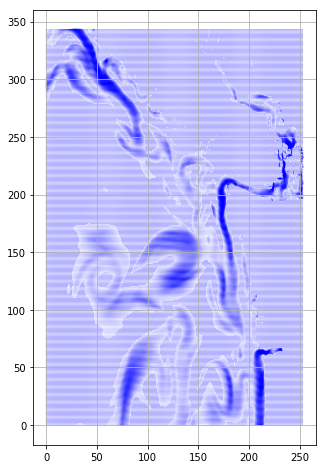

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(u_vel_BC_tzyx[0,0,...], v_vel_BC_tzyx[0,0,...], color='blue', pivot='mid')
ax.grid()

plt.show()


In [69]:
fname_coord = 'coordinates.nc'


grid_BC = xr.open_dataset(path+ fname_coord);

In [70]:
grid_BC.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:  (x: 715, y: 1021)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    nav_lon  (y, x) float32 -142.283 -142.256 -142.228 -142.2 -142.173 ...
    nav_lat  (y, x) float32 45.0491 45.0479 45.0467 45.0456 45.0444 45.0432 ...
    glamt    (y, x) float64 -142.3 -142.3 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamu    (y, x) float64 -142.3 -142.2 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamv    (y, x) float64 -142.3 -142.3 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamf    (y, x) float64 -142.3 -142.2 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    gphit    (y, x) float64 45.05 45.05 45.05 45.05 45.04 45.04 45.04 45.04 ...
    gphiu    (y, x) float64 45.05 45.05 45.05 45.05 45.04 45.04 45.04 45.04 ...
    gphiv    (y, x) float64 45.06 45.06 45.05 45.05 45.05 45.05 45.05 45.05 ...
    gphif    (

In [71]:
fname_coord_BC = 'coordinates.nc'

grid_JP = xr.open_dataset(path+ fname_coord_BC);
glamt = grid_JP.variables['glamt'][55:400,446:701]; gphit = grid_JP.variables['gphit'][55:400,446:701];
glamu = grid_JP.variables['glamu'][55:400,446:701]; gphiu = grid_JP.variables['gphiu'][55:400,446:701];
glamv = grid_JP.variables['glamv'][55:400,446:701]; gphiv = grid_JP.variables['gphiv'][55:400,446:701];


# First point
lonA = glamu[:,0:-1]
latA = gphiu[:,0:-1]
# Second point
lonB = glamu[:,1:]
latB = gphiu[:,1:]


bearing = cibc((latA,lonA),(latB,lonB))
angle_needed = 90 - bearing;

In [72]:
bearing.shape, glamt.shape ,gphit.shape

((345, 254), (345, 255), (345, 255))

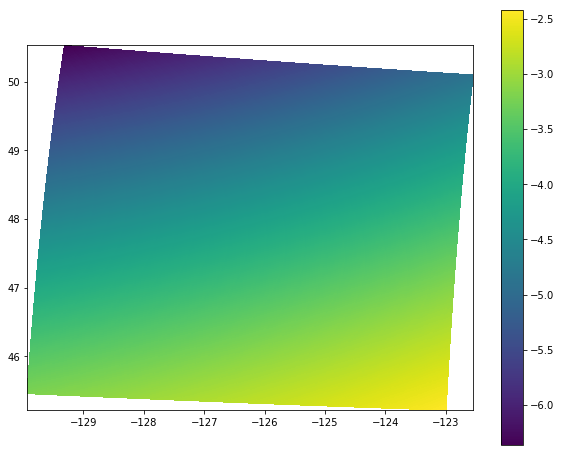

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(glamt, gphit, angle_needed)
fig.colorbar(mesh)
plt.show()

In [74]:
u_vel_BC_tzyx.shape

(43, 50, 344, 254)

In [75]:
angle_unrotated = np.empty((ang_vel_BC.shape[0],ang_vel_BC.shape[1],ang_vel_BC.shape[2], ang_vel_BC.shape[3]));


for p,q in enumerate(ang_vel_BC[:,...]):
    for i,j in enumerate(ang_vel_BC[p,:,...]):
        angle_unrotated[p,i,...] = ang_vel_BC[p,i,...] + angle_needed[1:,:];
                                
                                
u_unrotated = mag_vel_BC*np.cos(np.radians(angle_unrotated));
v_unrotated = mag_vel_BC*np.sin(np.radians(angle_unrotated));

                                


In [76]:
fname_coord_WCVI = 'coordinates_wcvi.nc';

with nc.Dataset(path+fname_coord_WCVI, 'r') as grid_WCVI:
    glamt_wcvi = grid_WCVI.variables['glamt'][0,:]; gphit_wcvi = grid_WCVI.variables['gphit'][0,:];
    glamu_wcvi = grid_WCVI.variables['glamu'][0,:]; gphiu_wcvi = grid_WCVI.variables['gphiu'][0,:];
    glamv_wcvi = grid_WCVI.variables['glamv'][0,:]; gphiv_wcvi = grid_WCVI.variables['gphiv'][0,:];
    
    
# First point
lonA_wcvi = glamu_wcvi[:,0:-1]
latA_wcvi = gphiu_wcvi[:,0:-1]
# Second point
lonB_wcvi = glamu_wcvi[:,1:]
latB_wcvi = gphiu_wcvi[:,1:]


bearing_wcvi = cibc((latA_wcvi,lonA_wcvi),(latB_wcvi,lonB_wcvi));
angle_needed_wcvi = 90 - bearing_wcvi;


In [77]:
angle_needed_wcvi.shape

(100, 69)

In [78]:
glamt_cut_JP = glamt[1:,1:]; gphit_cut_JP = gphit[1:,1:];

X = np.array(glamt_cut_JP).flatten(); Y = np.array(gphit_cut_JP).flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

u_unrotated_wcvi_t = np.empty((u_unrotated.shape[0],u_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
v_unrotated_wcvi_t = np.empty((v_unrotated.shape[0],v_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

#for p,q in enumerate(u_unrotated[:,...]):
#    for i,j in enumerate(u_unrotated[p,:,...]):
#        u_unrotated_wcvi_t[p,i,...] = griddata(points, u_unrotated[p,i,...].flatten(), xi, method= 'linear')
#        v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
for p,q in enumerate(u_unrotated[:,...]):
    for i,j in enumerate(v_unrotated[p,:,...]):
        u_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), \
                                                 xi, method= 'linear'), glamt_wcvi.shape)
        v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), \
                                                 xi, method= 'linear'), glamt_wcvi.shape)
#u_unrotated_wcvi_t = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
#v_unrotated_wcvi_t = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)

np.save('u_unrotated_wcvi_t_3D', u_unrotated_wcvi_t);
np.save('v_unrotated_wcvi_t_3D', v_unrotated_wcvi_t);

In [79]:
u_unrotated_wcvi_t = np.load('u_unrotated_wcvi_t_3D.npy'); v_unrotated_wcvi_t = np.load('v_unrotated_wcvi_t_3D.npy');

In [80]:
mag_vel_at_wcvi = np.sqrt(np.multiply(u_unrotated_wcvi_t,u_unrotated_wcvi_t), \
                          np.multiply(v_unrotated_wcvi_t,v_unrotated_wcvi_t));
ang_vel_at_wcvi = np.degrees(np.arctan2(v_unrotated_wcvi_t, u_unrotated_wcvi_t));

angle_unrotated_wcvi = ang_vel_at_wcvi[...,:,1:] - angle_needed_wcvi;

u_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.cos(np.radians(angle_unrotated_wcvi[...])));
v_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.sin(np.radians(angle_unrotated_wcvi[...])));

In [81]:
def stagger(ugrid, vgrid):
    u = np.add(ugrid[...,:-1], ugrid[...,1:]) / 2;
    v = np.add(vgrid[...,:-1, :], vgrid[...,1:, :]) / 2;
    return u[...,:, :], v[...,:, :]

In [82]:
u_rotated_WCVI, v_rotated_WCVI = stagger(u_unrotated_rotated_to_wcvi, v_unrotated_rotated_to_wcvi)

In [83]:
N = 5

U_wcvi_top = u_rotated_WCVI[...,-N:-1,:]; V_wcvi_top = v_rotated_WCVI[...,-N:-1,:];
U_wcvi_bottom = u_rotated_WCVI[...,0:N-1,:]; V_wcvi_bottom = v_rotated_WCVI[...,0:N-1,:];

U_wcvi_left = u_rotated_WCVI[...,:,0:N-1]; V_wcvi_left = v_rotated_WCVI[...,:,0:N-1];
U_wcvi_right = u_rotated_WCVI[...,:,-N:-1]; V_wcvi_right = v_rotated_WCVI[...,:,-N:-1];


np.save('U_3D_wcvi_top', U_wcvi_top); np.save('V_3D_wcvi_top', V_wcvi_top);
np.save('U_3D_wcvi_bottom', U_wcvi_bottom); np.save('V_3D_wcvi_bottom', V_wcvi_bottom);
np.save('U_3D_wcvi_left', U_wcvi_left); np.save('V_3D_wcvi_left', V_wcvi_left);
np.save('U_3D_wcvi_right', U_wcvi_right); np.save('V_3D_wcvi_right', V_wcvi_right);





In [84]:
!ls

OSError: [Errno 12] Cannot allocate memory

In [ ]:
ang_vel_at_wcvi.shape, angle_needed_wcvi.shape, angle_unrotated_wcvi.shape, u_rotated_WCVI.shape, v_rotated_WCVI.shape

In [ ]:
v_unrotated_wcvi_t.shape

In [ ]:
u_rotated_WCVI.shape

In [ ]:
U_wcvi_bottom.shape

In [ ]:
u_unrotated_wcvi_t.shape

In [ ]:
glamt_wcvi.shape

In [ ]:
Y.shape

In [ ]:
U_vel_BC.shape

In [ ]:
nav_lat_U.shape

In [ ]:
np.min(nav_lat_U)

In [ ]:
344*254

In [ ]:
X.shape

In [ ]:
votemper, vosaline, nav_lon, nav_lat, time_counter_bnds, sossheig

In [15]:
gridT = xr.open_dataset('/ocean/ssahu/JP_BC/cat_42_days_T.nc')

mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:400,446:701]
umask_JP = mask.variables['umask'][0,:,55:400,446:701]
vmask_JP = mask.variables['vmask'][0,:,55:400,446:701]


ssh_unfiltered = np.array(gridT['sossheig'][1:,55:400,446:701])
votemper_unfiltered = np.array(gridT['votemper'][1:,:,55:400,446:701])
vosaline_unfiltered = np.array(gridT['vosaline'][1:,:,55:400,446:701])


In [16]:
ssh_unfiltered.shape

(42, 345, 255)

In [17]:
votemper_unfiltered.shape

(42, 50, 345, 255)

In [18]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...]
    glamt_wcvi = coord.variables['glamt'][0,...]
    glamu_wcvi = coord.variables['glamu'][0,...]
    gphiu_wcvi = coord.variables['gphiu'][0,...]
    glamv_wcvi = coord.variables['glamv'][0,...]
    gphiv_wcvi = coord.variables['gphiv'][0,...]


In [19]:
N = 10

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];
glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];

glamt_wcvi_bc_bottom = glamt_wcvi[0:N-1,:]; gphit_wcvi_bc_bottom = gphit_wcvi[0:N-1,:];
glamt_wcvi_bc_top = glamt_wcvi[-N:-1,:]; gphit_wcvi_bc_top = gphit_wcvi[-N:-1,:];

votemper_wcvi_top = np.empty((votemper_unfiltered.shape[0],votemper_unfiltered.shape[1],glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]))
votemper_wcvi_bottom = np.empty((votemper_unfiltered.shape[0],votemper_unfiltered.shape[1],glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]))

vosaline_wcvi_top = np.empty((vosaline_unfiltered.shape[0],vosaline_unfiltered.shape[1],glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]))
vosaline_wcvi_bottom = np.empty((vosaline_unfiltered.shape[0],vosaline_unfiltered.shape[1],glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]))


votemper_wcvi_left = np.empty((votemper_unfiltered.shape[0],votemper_unfiltered.shape[1],glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]))
votemper_wcvi_right = np.empty((votemper_unfiltered.shape[0],votemper_unfiltered.shape[1],glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]))

vosaline_wcvi_left = np.empty((vosaline_unfiltered.shape[0],vosaline_unfiltered.shape[1],glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]))
vosaline_wcvi_right = np.empty((vosaline_unfiltered.shape[0],vosaline_unfiltered.shape[1],glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]))


ssh_wcvi_left = np.empty((ssh_unfiltered.shape[0],glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]))
ssh_wcvi_right = np.empty((ssh_unfiltered.shape[0],glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]))


ssh_wcvi_top = np.empty((ssh_unfiltered.shape[0],glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]))
ssh_wcvi_bottom = np.empty((ssh_unfiltered.shape[0],glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]))

In [20]:
glamt_wcvi_bc_left.shape

(390, 9)

In [21]:
ssh_wcvi_left.shape

(42, 390, 9)